# SAM 40 dataset

**Dataset:** [SAM 40: Dataset](
https://figshare.com/articles/dataset/SAM_40_Dataset_of_40_Subject_EEG_Recordings_to_Monitor_the_Induced-Stress_while_performing_Stroop_Color-Word_Test_Arithmetic_Task_and_Mirror_Image_Recognition_Task/14562090?file=27956376)

**Article:** [SAM 40: Dataset of 40 subject EEG recordings to monitor the induced-stress while performing Stroop color-word test, arithmetic task, and mirror image recognition task](https://www.sciencedirect.com/science/article/pii/S2352340921010465?ref=pdf_download&fr=RR-2&rr=96adf844ce23e918)


Questions:
1. могу ли я сделать видео визуализацию по картинкой головы. То есть чтобы было видео как сигнал меняется со временем по голове.
2. Есть ли какая-то проверка на линейнную зависимость каналов


MNE continuous data working

# Import libraries


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt
plt.ion()


import mne
mne.set_log_level('error')


import os
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.options.display.max_columns = None # показываем все колонки

In [ ]:
# загрузка
sam40_full_epochs = mne.read_epochs(r'epochs\sam40_full_epochs.fif', preload=True)

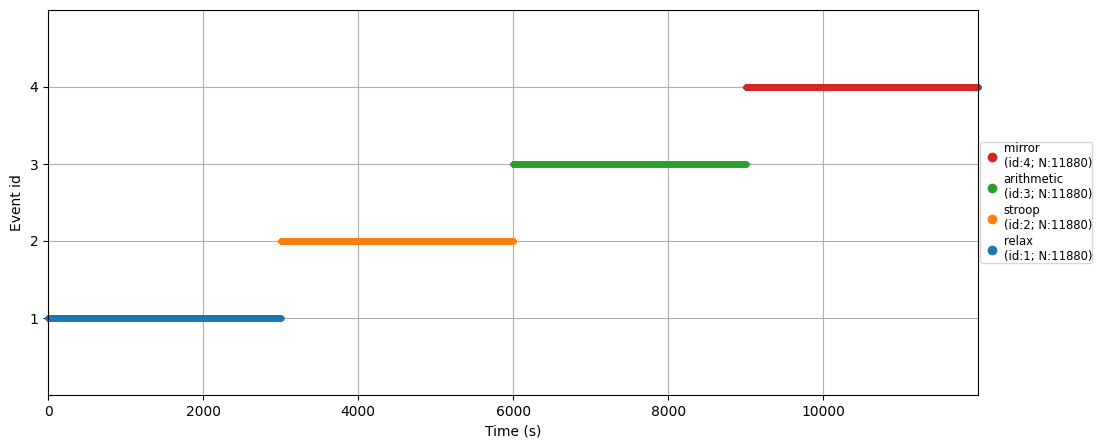

In [ ]:

fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(
    sam40_full_epochs.events,
    sam40_full_epochs.info["sfreq"],
    event_id=sam40_full_epochs.event_id,
    axes=ax
)
plt.show()

# Reshaping

In [ ]:
X = sam40_full_epochs.get_data(copy=False) 
y = sam40_full_epochs.events[:, 2]       

shape = X.shape
n_epochs, n_channels, n_times = X.shape
X = X.reshape(n_epochs, n_channels * n_times)


print(f"X исходная: {shape} (эпохи, каналы, время)")
print(f"X после reshape: {X.shape} (эпохи, признаки)")
print(f"y: {y.shape} (метки классов)")

X исходная: (46080, 12, 129) (эпохи, каналы, время)
X после reshape: (46080, 1548) (эпохи, признаки)
y: (46080,) (метки классов)


In [ ]:
session_groups = sam40_full_epochs.metadata["session"].values
subject_groups = sam40_full_epochs.metadata["subject"].values

print(f"subject_groups: {subject_groups.shape} ")
print(f"session_groups: {session_groups.shape} ")

subject_groups: (46080,) 
session_groups: (46080,) 


# Stratified K-Fold Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold,  cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Для бинарной классификации
    n_estimators=100,             # Количество деревьев (можно увеличить)
    learning_rate=0.2,            # Скорость обучения
    max_depth=7,                  # Максимальная глубина дерева (можно настроить)
    eval_metric='logloss',        # Метрика для бинарной классификации
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}


cv_results = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)


metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(2)


metrics_table

# Cross-subject

In [ ]:
import xgboost as xgb
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score, f1_score
)

# --- 3. Классификатор ---
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.2,
    max_depth=7,
    eval_metric='logloss',
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

# --- 4. CV ---
logo = LeaveOneGroupOut()

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(
    pipeline, X, y,
    cv=logo.split(X, y, groups=subject_groups),
    scoring=scoring,
    return_train_score=False
)

# --- 5. Результаты ---
metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(2)

metrics_table

,accuracy,precision,recall,f1
0,0.7682,0.7731,0.9780,0.8636
1,0.7630,0.7604,0.9988,0.8634
2,0.6241,0.7305,0.7905,0.7593
3,0.7413,0.7531,0.9745,0.8496
4,0.7448,0.7545,0.9780,0.8518
5,0.6172,0.8079,0.6424,0.7157
6,0.6241,0.7315,0.7882,0.7588
7,0.6250,0.7634,0.7245,0.7435
8,0.7639,0.7857,0.9421,0.8568
9,0.6224,0.7334,0.7801,0.7560


# Cross-session

In [ ]:
import xgboost as xgb
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score, f1_score
)

# --- 3. Классификатор ---
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.2,
    max_depth=7,
    eval_metric='logloss',
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

# --- 4. CV ---
logo = LeaveOneGroupOut()

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(
    pipeline, X, y,
    cv=logo.split(X, y, groups=session_groups),
    scoring=scoring,
    return_train_score=False
)

# --- 5. Результаты ---
metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(2)

metrics_table

,accuracy,precision,recall,f1
0,0.7264,0.7799,0.8849,0.8291
1,0.7260,0.7623,0.9222,0.8347
2,0.7291,0.7740,0.9023,0.8332
mean,0.7272,0.7721,0.9031,0.8323


# GridSearch

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier
# import numpy as np

# # Параметры для бинарной классификации
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'objective': ['binary:logistic'],  # бинарная классификация
#     'use_label_encoder': [False],     # чтобы избежать предупреждений
#     'eval_metric': ['logloss']        # метрика для бинарной классификации
# }

# # Создаем GridSearchCV объект
# grid_search = GridSearchCV(
#     estimator=XGBClassifier(random_state=42),
#     param_grid=param_grid,
#     scoring='accuracy',  # или другая подходящая метрика для бинарной классификации
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import classification_report

# print("Best parameters found by GridSearchCV:")
# print(grid_search.best_params_)

# best_xgb_model = grid_search.best_estimator_

# y_pred_tuned_xgb = best_xgb_model.predict(X_test)

# print("\nTuned XGBoost Model - Classification Report:")
# print(classification_report(y_test, y_pred_tuned_xgb, target_names=['focused', 'unfocused']))

In [ ]:
# Best parameters found by GridSearchCV:
# {'eval_metric': 'logloss', 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'objective': 'binary:logistic', 'use_label_encoder': False}

# Tuned XGBoost Model - Classification Report:
#               precision    recall  f1-score   support

#      focused       0.86      0.87      0.86      8628
#    unfocused       0.87      0.86      0.86      8640

#     accuracy                           0.86     17268
#    macro avg       0.86      0.86      0.86     17268
# weighted avg       0.86      0.86      0.86     17268